# Visual Testing

Some subtle and unusual errors in signal reconstruction can creep in if certain parts of the symmetric decorrelation routine are bugged; accordingly, even if the automated test comparing the reconstructed signals against each other passes, it is important to look at the graph in person and verify that it looks reasonable.

This code is based off the Blind Source Separation notebook included in Scikit-learn's example library:
https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#blind-source-separation-using-fastica

In [1]:
from cml_tools import fastica, whiten
from cml_tests.test_fastica import TestSignalReconstruction

OMP: Warning #182: OMP_PROC_BIND: ignored because KMP_AFFINITY has been defined
OMP: Warning #182: OMP_PLACES: ignored because KMP_AFFINITY has been defined


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import signal, linalg
from sklearn.decomposition import _fastica as sk_fastica

In [3]:
X, A, S = TestSignalReconstruction.gen_test_signals()
W = np.random.normal(size=A.shape)

sk_ica = sk_fastica.FastICA(n_components=3,
                            w_init=np.copy(W),
                            whiten_solver='svd',
                            whiten='unit-variance',
                            # defaults
                            max_iter=200,
                            tol=1e-04)

sk_S = sk_ica.fit_transform(np.copy(X.T)).T
sk_A = sk_ica.mixing_

In [4]:
# do the torch stuff
X0 = torch.from_numpy(X).clone()

X1, K, fi_mean = whiten.learn_whitening(X0, 3)
fi_W, n_iter = fastica.fastica(X1, torch.from_numpy(W).clone())

fi_S = fastica.recover_S_from_WX1(fi_W, X1)
fi_A = fastica.recover_A_from_WK(fi_W, K)

unit_S = torch.clone(fi_S)
unit_A = torch.clone(fi_A)
fastica.scale_to_unit_variance(unit_S, unit_A.T)

(tensor([[-0.3887,  0.5849,  0.9141,  ..., -0.9807, -0.6442, -1.2011],
         [-0.4461, -0.0051, -0.1974,  ...,  0.5565,  0.9649,  0.7539],
         [ 1.4233,  1.0097,  1.4904,  ..., -1.3729, -1.6715,  1.6484]],
        dtype=torch.float64),
 tensor([[ 0.4997,  2.0138,  0.9847],
         [-0.8958, -0.9802, -0.8723],
         [-1.5564, -1.0222, -2.0429]], dtype=torch.float64),
 tensor([[1.0003],
         [1.0003],
         [1.0003]], dtype=torch.float64))

In [5]:
print(f'sklearn iterations: {sk_ica.n_iter_}')
print(f'fastica iterations: {n_iter}')

sklearn iterations: 3
fastica iterations: 3


In [6]:
# Basic check (also in test_fastica)
sk_X = np.dot(sk_A, sk_S) + sk_ica.mean_[:, np.newaxis]
fi_X = (fi_A @ fi_S) + fi_mean
unit_X = (unit_A @ unit_S) + fi_mean

assert np.allclose(X, sk_X)
assert np.allclose(X, fi_X.numpy())
assert np.allclose(X, unit_X.numpy())
assert np.allclose(sk_X, fi_X.numpy())

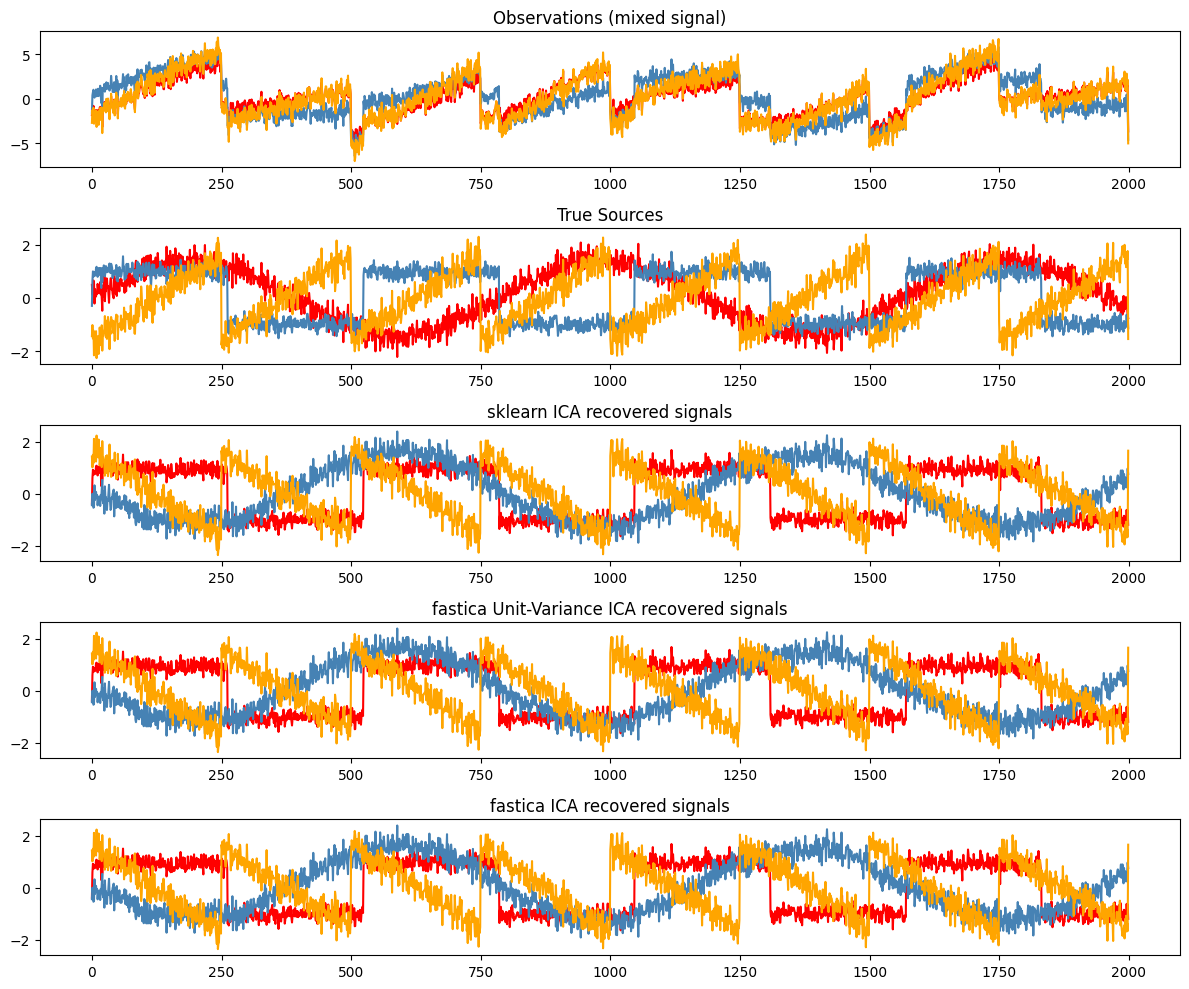

In [7]:
plt.figure(figsize=(12, 10))

models = [X.T, S.T, sk_S.T, unit_S.T.numpy(), fi_S.T.numpy()]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "sklearn ICA recovered signals",
    "fastica Unit-Variance ICA recovered signals",
    "fastica ICA recovered signals"
]
colors = ["red", "steelblue", "orange"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(5, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

# Toy Data Timing

In [8]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

In [9]:
%%timeit
timing_ica = sk_fastica.FastICA(n_components=3,
                                w_init=np.copy(W),
                                whiten_solver='eigh',
                                whiten='unit-variance',
                                max_iter=2000,
                                tol=0)
timing_ica.fit_transform(np.copy(X.T))

1.21 s ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
X0 = torch.from_numpy(X).clone()
W0 = torch.from_numpy(W).clone()

In [11]:
%%timeit
# do the torch stuff
X1, K, fi_mean = whiten.learn_whitening(X0, 3)
fi_W, n_iter = fastica.fastica(X1, W0)

fi_S = fastica.recover_S_from_WX1(fi_W, X1)
fi_A = fastica.recover_A_from_WK(fi_W, K)
fastica.scale_to_unit_variance(fi_S, fi_A.T)

26.5 ms ± 44.2 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
